In [48]:
import pandas as pd
from datetime import datetime
import numpy as np
import matplotlib.pyplot as plt
from sklearn.preprocessing import MinMaxScaler
from scipy.signal import find_peaks
from scipy.stats import shapiro, normaltest, skew, kurtosis


In [49]:
# Define window sizes and thresholds
window_sizes_and_thresholds = [(3, 3.0), (5, 3.0), (7, 3.0), (11, 3.0), (13, 3.0), (17, 3.0)]

In [50]:
# Load data
df = pd.read_csv("data/data_live.csv")
columns = ["price", "volume", "trade_ts"]
timestamp_format = "%Y-%m-%d %H:%M:%S.%f%z"
df = df[columns]
df["trade_ts"] = df["trade_ts"].apply(lambda a: datetime.strptime(a, timestamp_format))
df['trade_ts'] = pd.to_datetime(df["trade_ts"], format=timestamp_format)
df = df.set_index("trade_ts")


In [51]:
# Explore data
print(df.describe())
print(df.info())
df.head()

               price        volume
count   11200.000000  11200.000000
mean   101087.206058      0.010152
std        87.607842      0.036708
min    100895.530000      0.000010
25%    101011.100000      0.000200
50%    101111.120000      0.000840
75%    101151.880000      0.004100
max    101259.250000      1.296180
<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 11200 entries, 2024-12-14 22:52:18.522000+00:00 to 2024-12-14 22:02:02.328000+00:00
Data columns (total 2 columns):
 #   Column  Non-Null Count  Dtype  
---  ------  --------------  -----  
 0   price   11200 non-null  float64
 1   volume  11200 non-null  float64
dtypes: float64(2)
memory usage: 262.5 KB
None


,price,volume
trade_ts,,
2024-12-14 22:52:18.522000+00:00,101212.42,0.00030
2024-12-14 22:52:18.420000+00:00,101212.42,0.00114
2024-12-14 22:52:18.083000+00:00,101212.42,0.00045
2024-12-14 22:52:17.688000+00:00,101212.41,0.00324
2024-12-14 22:52:17.670000+00:00,101212.41,0.00146


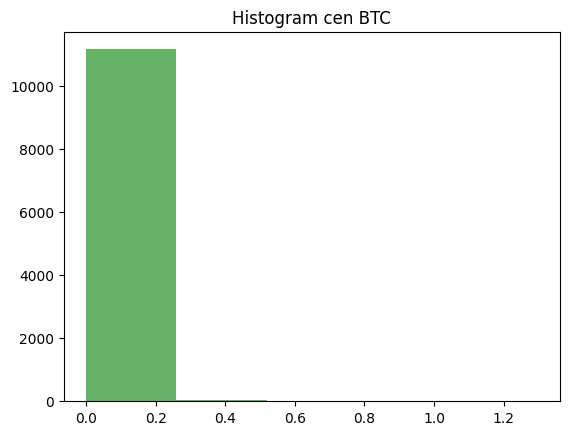

Shapiro-Wilk Test p-value: 2.5957505820718008e-110
D'Agostino and Pearson's Test p-value: 0.0
Skośność: 12.037610808186576
Kurtosis: 261.8992811863931


C:\Users\seksc\Documents\sem7\anomaly-detection\.venv\lib\site-packages\scipy\stats\_axis_nan_policy.py:573: UserWarning: scipy.stats.shapiro: For N > 5000, computed p-value may not be accurate. Current N is 11200.
  res = hypotest_fun_out(*samples, **kwds)


In [62]:

prices = df['volume']

# Histogram
plt.hist(prices, bins=5, density=False, alpha=0.6, color='g')
plt.title("Histogram cen BTC")
plt.show()

# Testy normalności
stat, p_shapiro = shapiro(prices)
stat2, p_dagostino = normaltest(prices)

print(f"Shapiro-Wilk Test p-value: {p_shapiro}")
print(f"D'Agostino and Pearson's Test p-value: {p_dagostino}")

# Skośność i kurtoza
print(f"Skośność: {skew(prices)}")
print(f"Kurtosis: {kurtosis(prices, fisher=True)}")

In [53]:
# Preprocessing
df['volume_smooth'] = df['volume'].rolling(window=window_sizes_and_thresholds[0][0]).mean()

scaler = MinMaxScaler()
df['volume_normalized'] = scaler.fit_transform(df[['volume']])
df['volume_diff'] = df['volume'] - df['volume'].shift(1)
df['volume_pct_change'] = df['volume'].pct_change()
df["hour"] = df.index.hour


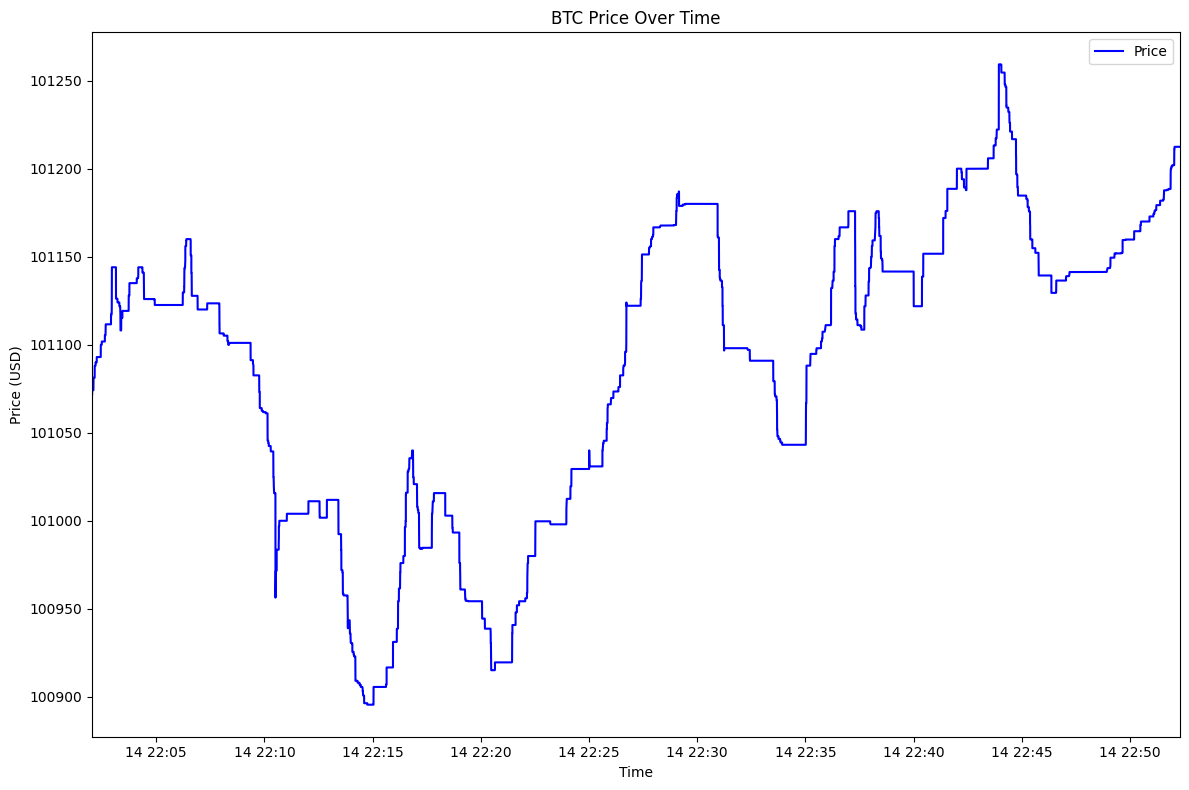

In [54]:
fig = plt.figure(figsize=(12, 8))
plt.plot(df.index, df["price"], label="Price", color="blue", linewidth=1.5)
plt.title("BTC Price Over Time")
plt.xlabel("Time")
plt.ylabel("Price (USD)")
# plt.ylim([99000, 100000])
plt.xlim([min(df.index), max(df.index)])
# plt.xticks(df.index, , rotation=45)
# print(type(df.index.iloc[0]))
# print(df.index)
plt.legend()
plt.tight_layout()
plt.show()



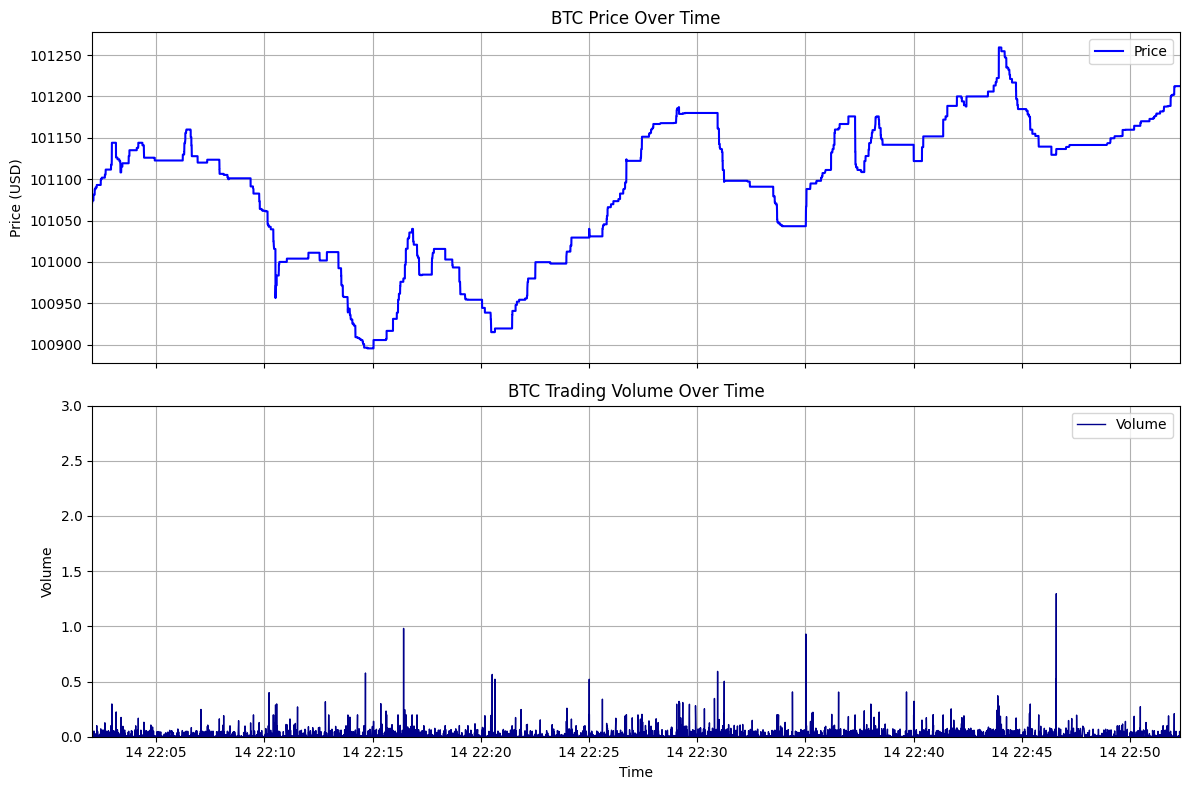

In [55]:
# Plot Price and Volume
fig, ax = plt.subplots(2, 1, figsize=(12, 8), sharex=True)

# Plot Price
ax[0].plot(df.index, df["price"], label="Price", color="blue", linewidth=1.5)
ax[0].set_title("BTC Price Over Time")
ax[0].set_ylabel("Price (USD)")
ax[0].set_xlim([min(df.index), max(df.index)])
# ax[0].set_ylim([99000, 100000])
ax[0].grid(True)
ax[0].legend()

# Plot Volume
ax[1].plot(df.index, df["volume"], label="Volume", color="darkblue", linewidth=1)
# ax[1].plot(df.index, df["volume_smooth"], label="Volume Smooth", color="red", linewidth=0.5)
ax[1].set_title("BTC Trading Volume Over Time")
ax[1].set_ylabel("Volume")
ax[1].set_xlabel("Time")
ax[1].set_xlim([min(df.index), max(df.index)])
ax[1].set_ylim([0,3])
ax[1].grid(True)
ax[1].legend()

plt.tight_layout()
plt.show()

fig.savefig("figures/price-over-time")



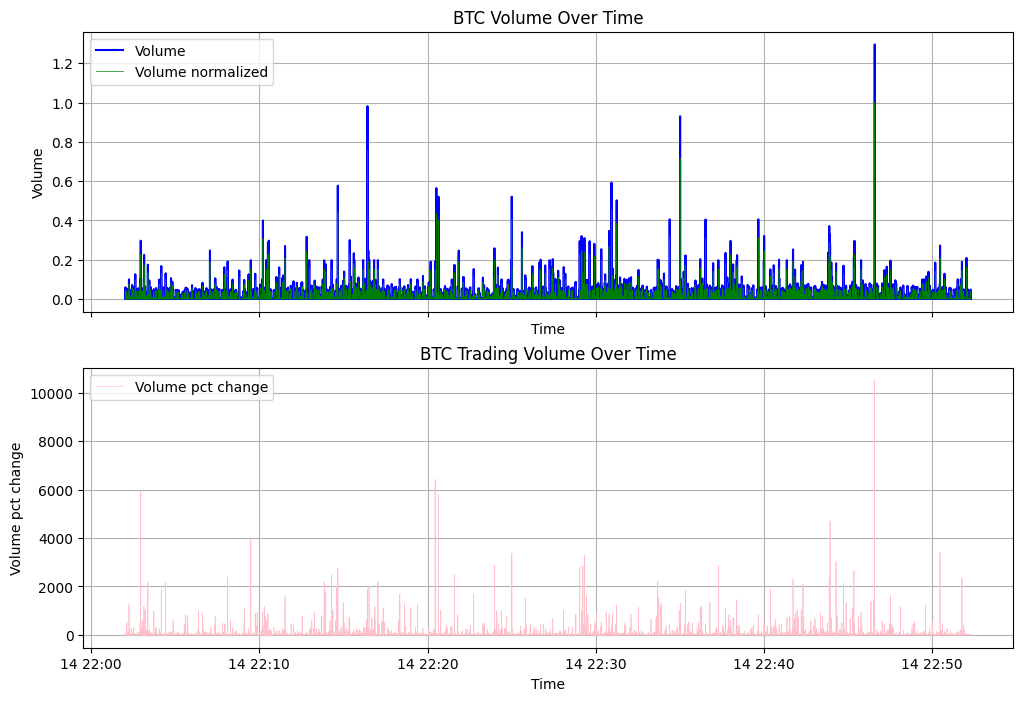

In [56]:
# Plot Price and Volume
fig, ax = plt.subplots(2, 1, figsize=(12, 8), sharex=True)

# Plot Price
ax[0].plot(df.index, df["volume"], label="Volume", color="blue", linewidth=1.5)
ax[0].plot(df.index, df["volume_normalized"], label="Volume normalized", color="green", linewidth=0.5)
ax[0].set_title("BTC Volume Over Time")
ax[0].set_ylabel("Volume")
ax[0].set_xlabel("Time")
ax[0].grid(True)
ax[0].legend()

# Plot Volume
# ax[1].plot(df.index, df["volume"], label="Volume", color="orange", linewidth=1)
ax[1].plot(df.index, df["volume_pct_change"], label="Volume pct change", color="pink", linewidth=0.5)
ax[1].set_title("BTC Trading Volume Over Time")
ax[1].set_ylabel("Volume pct change")
ax[1].set_xlabel("Time")
ax[1].grid(True)
ax[1].legend()

# Adjust layout and show the plots
# plt.tight_layout()
plt.show()

In [57]:
# Function to detect anomalies using sliding window and z-scores
def detect_anomalies_sliding_window(dataframe, column, window_size_seconds, threshold):
    """
    Detect anomalies using z-scores, applying a sliding window where the rolling window is based on seconds.
    """
    window = f"{window_size_seconds}s"
    rolling_mean = dataframe[column].rolling(window=window, min_periods=1, closed='both').mean()
    rolling_std = dataframe[column].rolling(window=window, min_periods=1, closed='both').std()
    z_scores = (dataframe[column] - rolling_mean) / rolling_std
    anomalies = np.abs(z_scores) > threshold
    return anomalies


Window Size: 3s, Threshold: 3.0
{'price': np.int64(252), 'volume': np.int64(292)}
Window Size: 5s, Threshold: 3.0
{'price': np.int64(367), 'volume': np.int64(382)}
Window Size: 7s, Threshold: 3.0
{'price': np.int64(441), 'volume': np.int64(418)}
Window Size: 11s, Threshold: 3.0
{'price': np.int64(581), 'volume': np.int64(373)}
Window Size: 13s, Threshold: 3.0
{'price': np.int64(612), 'volume': np.int64(357)}
Window Size: 17s, Threshold: 3.0
{'price': np.int64(673), 'volume': np.int64(330)}


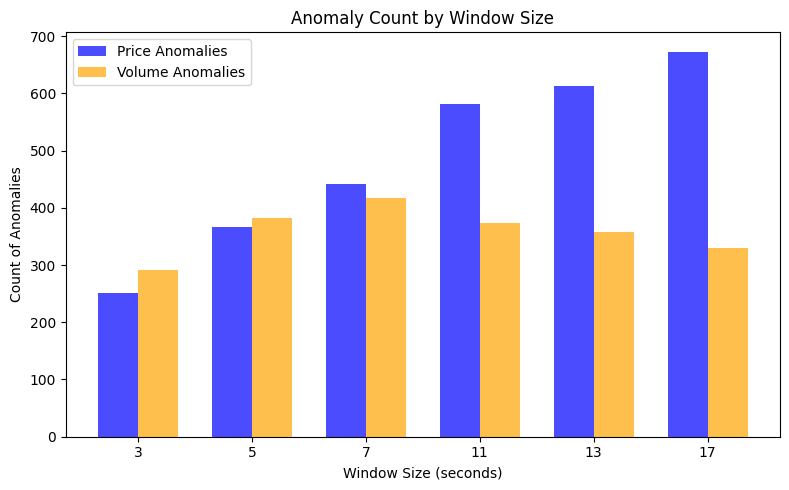

In [58]:
# Apply anomaly detection for each window size and threshold
anomalies_summary = {}

for window_size, threshold in window_sizes_and_thresholds:
    anomalies_price = detect_anomalies_sliding_window(df, 'price', window_size, threshold)
    anomalies_volume = detect_anomalies_sliding_window(df, 'volume', window_size, threshold)
    
    anomalies_count = {
        'price': anomalies_price.sum(),
        'volume': anomalies_volume.sum()
    }
    anomalies_summary[window_size] = anomalies_count
    print(f"Window Size: {window_size}s, Threshold: {threshold}")
    print(anomalies_count)

# Plot anomaly counts
window_sizes = [item[0] for item in window_sizes_and_thresholds]
price_anomalies = [anomalies_summary[window]['price'] for window in window_sizes]
volume_anomalies = [anomalies_summary[window]['volume'] for window in window_sizes]

x = np.arange(len(window_sizes))
width = 0.35

fig, ax = plt.subplots(figsize=(8, 5))
ax.bar(x - width/2, price_anomalies, width, label='Price Anomalies', color='blue', alpha=0.7)
ax.bar(x + width/2, volume_anomalies, width, label='Volume Anomalies', color='orange', alpha=0.7)

ax.set_xlabel('Window Size (seconds)')
ax.set_ylabel('Count of Anomalies')
ax.set_title('Anomaly Count by Window Size')
ax.set_xticks(x)
ax.set_xticklabels(window_sizes)
ax.legend()

plt.tight_layout()
plt.show()


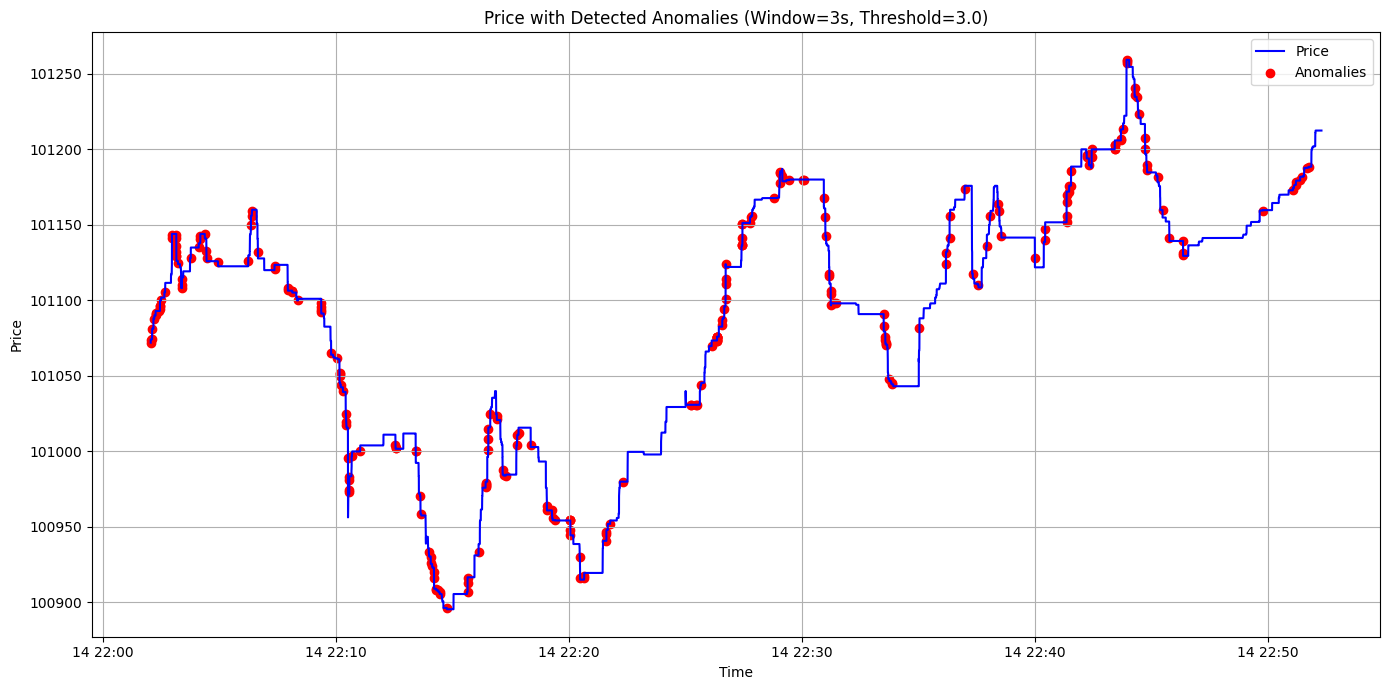

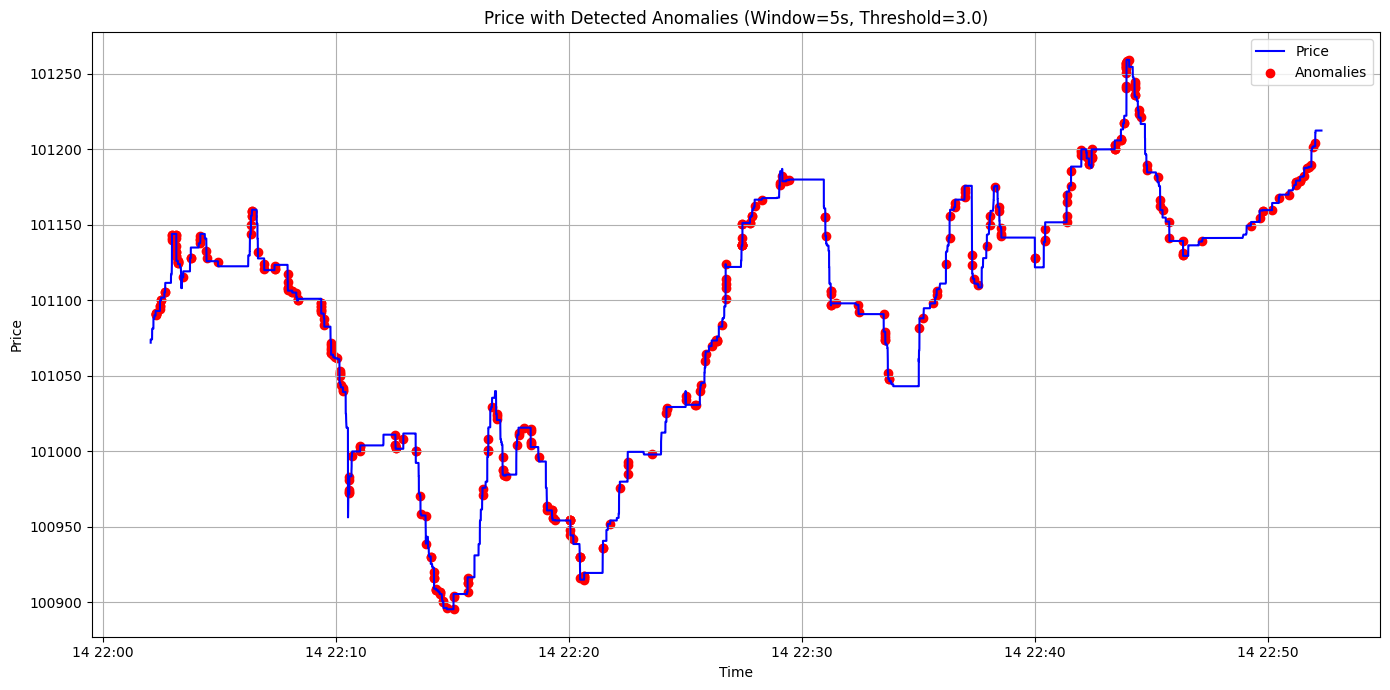

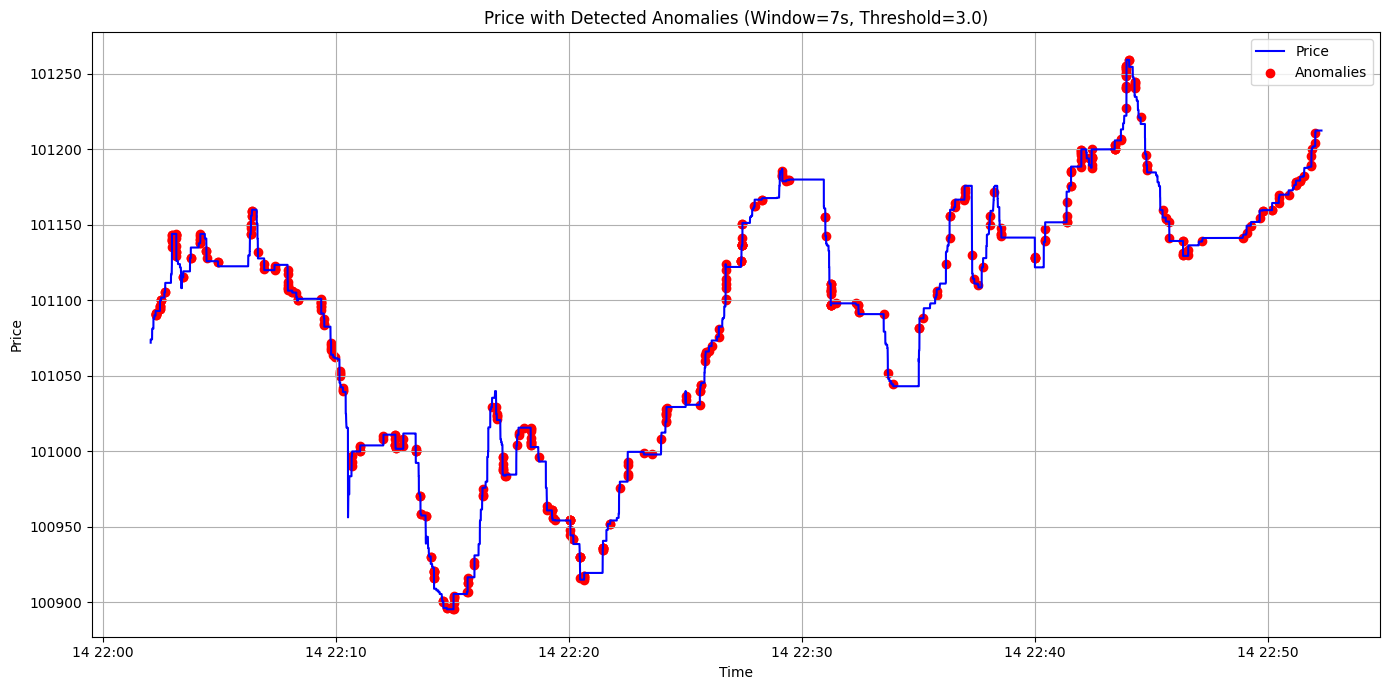

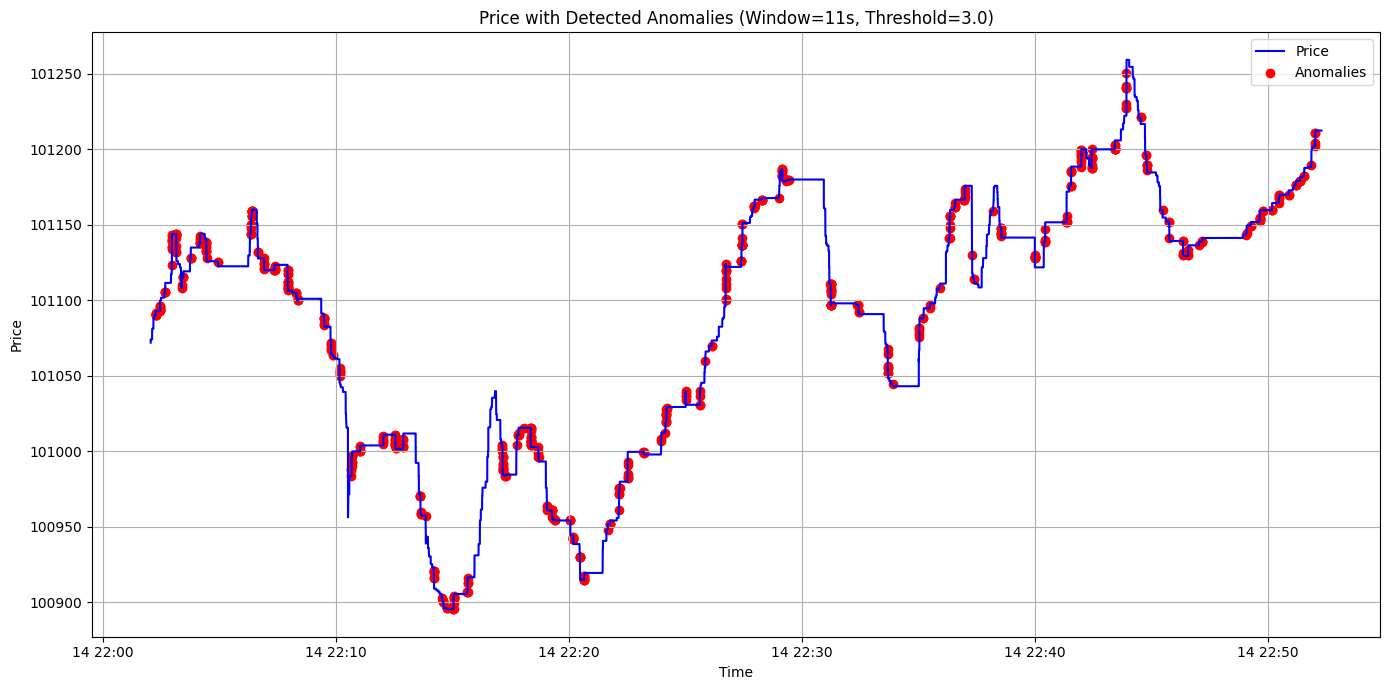

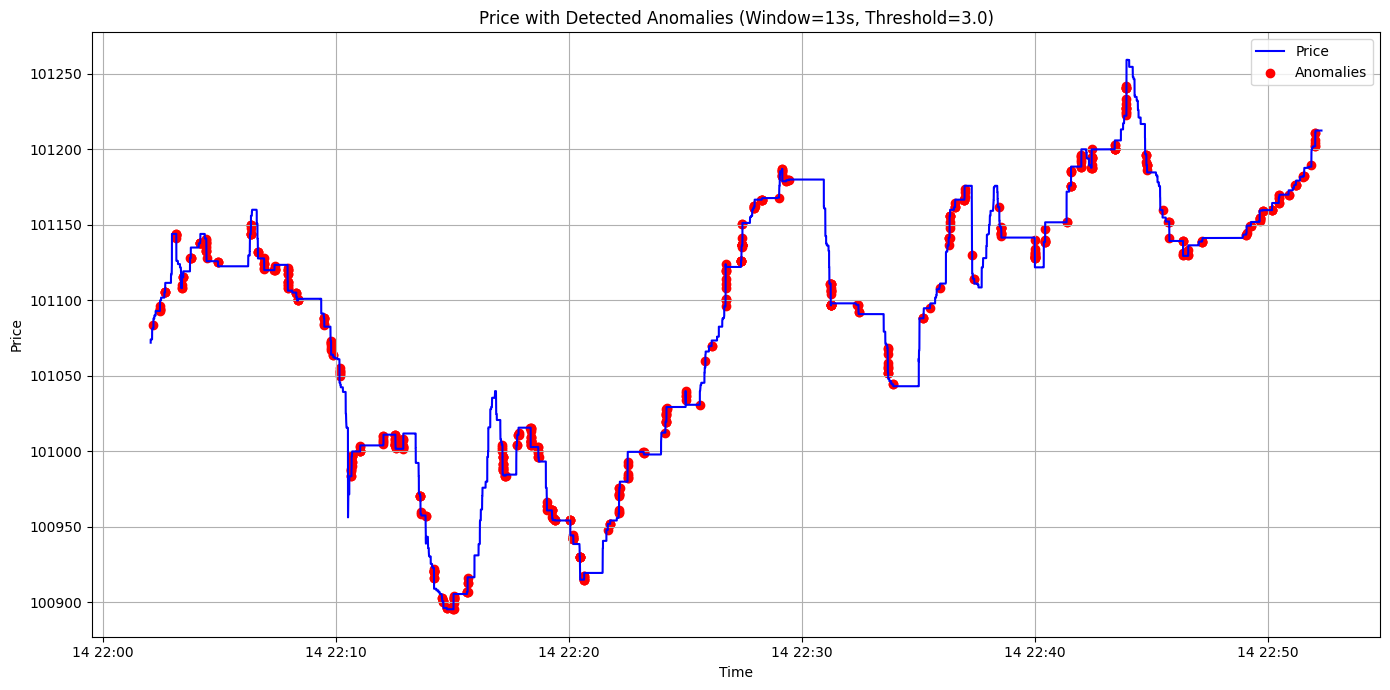

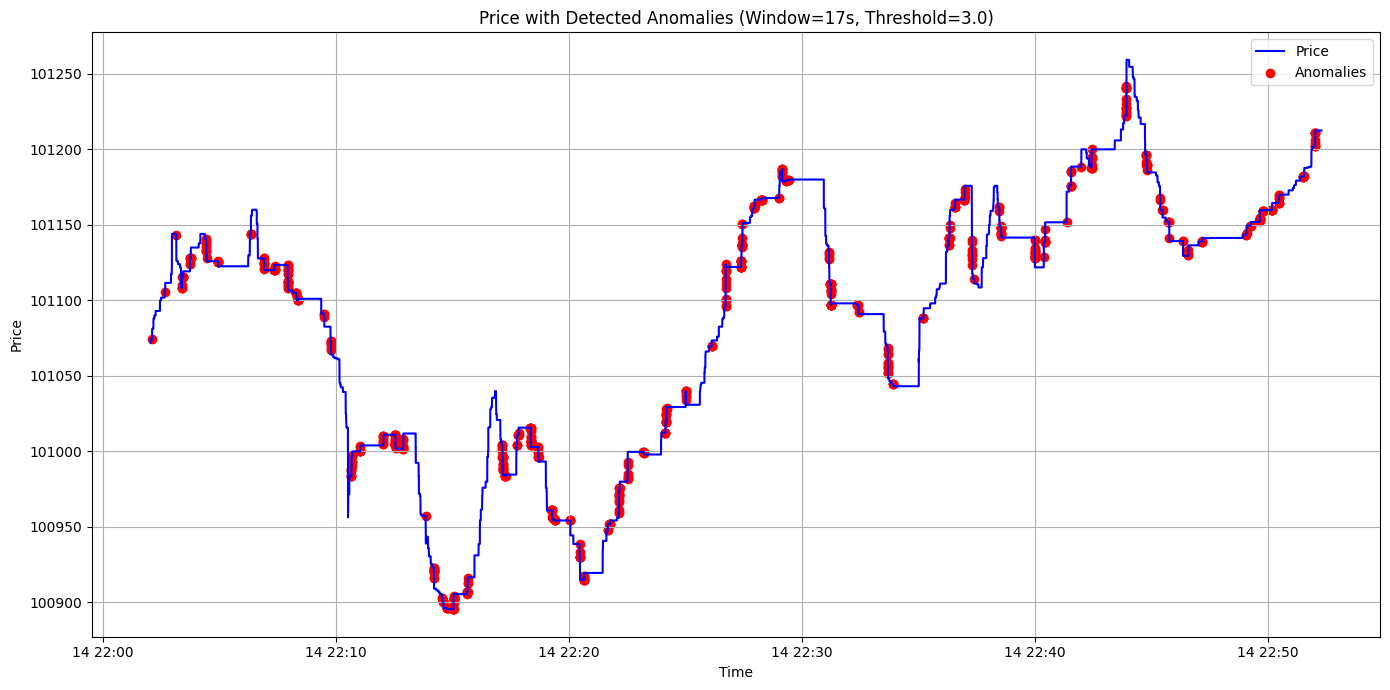

Window: 3s, Threshold: 3.0, Count: 252, Percentage: 2.25%
Window: 5s, Threshold: 3.0, Count: 367, Percentage: 3.28%
Window: 7s, Threshold: 3.0, Count: 441, Percentage: 3.94%
Window: 11s, Threshold: 3.0, Count: 581, Percentage: 5.19%
Window: 13s, Threshold: 3.0, Count: 612, Percentage: 5.46%
Window: 17s, Threshold: 3.0, Count: 673, Percentage: 6.01%


In [59]:
# Function to plot anomalies per window
def plot_anomalies_per_window_sliding(df, column, window_sizes_and_thresholds):
    stats_table = []
    for window_size, threshold in window_sizes_and_thresholds:
        anomalies = detect_anomalies_sliding_window(df, column, window_size, threshold)
        anomaly_points = df[column][anomalies]
        stat = f"Window: {window_size}s, Threshold: {threshold}, Count: {len(anomaly_points)}, Percentage: {len(anomaly_points) / len(df) * 100:.2f}%"
        stats_table.append(stat)
        
        plt.figure(figsize=(14, 7))
        plt.plot(df.index, df[column], label=column.capitalize(), color='blue', linewidth=1.5)
        plt.scatter(anomaly_points.index, anomaly_points, label='Anomalies', color='red')
        plt.title(f"{column.capitalize()} with Detected Anomalies (Window={window_size}s, Threshold={threshold})")
        plt.xlabel("Time")
        plt.ylabel(column.capitalize())
        plt.grid(True)
        plt.legend()
        plt.tight_layout()
        plt.show()
        
    for stat in stats_table:
        print(stat)

plot_anomalies_per_window_sliding(df, "price", window_sizes_and_thresholds)


# For finnhub 2h 6.12.2024
Anomaly Count for 4s: 3222; 5%
Anomaly Count for 8s: 3105; 5%
Anomaly Count for 12s: 2866; 4%
Anomaly Count for 16s: 2546; 4%
Anomaly Count for 20s: 2389; 4%
Anomaly Count for 24s: 2256; 3%
Anomaly Count for 28s: 2231; 3%
Anomaly Count for 32s: 2060; 3%
The average percent of anomalies per different windows is 3.88% of the total

# For finnhub 2h 7.12.2024
Anomaly Count for 4s: 2215; 5%
Anomaly Count for 8s: 2592; 6%
Anomaly Count for 12s: 2269; 5%
Anomaly Count for 16s: 2265; 5%
Anomaly Count for 20s: 2154; 5%
Anomaly Count for 24s: 2014; 4%
Anomaly Count for 28s: 1948; 4%
Anomaly Count for 32s: 1818; 4%
The average percent of anomalies per different windows is 4.75% of the total

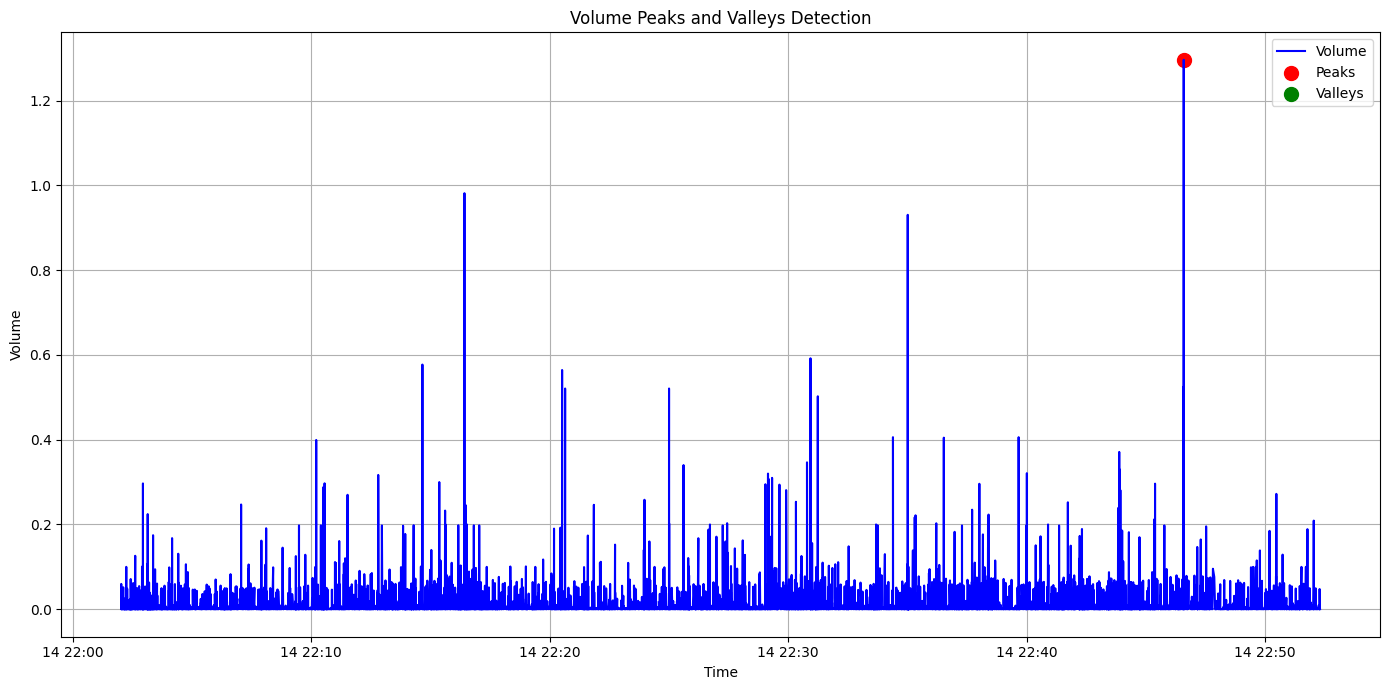

Peaks:
                                      price   volume  volume_smooth  \
trade_ts                                                             
2024-12-14 22:46:35.517000+00:00  101130.0  1.29618       0.432557   

                                  volume_normalized  volume_diff  \
trade_ts                                                           
2024-12-14 22:46:35.517000+00:00                1.0      1.29474   

                                  volume_pct_change  hour  peak_anomaly  \
trade_ts                                                                  
2024-12-14 22:46:35.517000+00:00            899.125    22             1   

                                  valley_anomaly  
trade_ts                                          
2024-12-14 22:46:35.517000+00:00               0  
Valleys:
 Empty DataFrame
Columns: [price, volume, volume_smooth, volume_normalized, volume_diff, volume_pct_change, hour, peak_anomaly, valley_anomaly]
Index: []


In [60]:
# Peaks and Valleys Detection
def detect_peaks_and_valleys(input_df, column, prominence_peaks=50, prominence_valleys=50):
    peaks, _ = find_peaks(input_df[column], prominence=prominence_peaks)
    inverted_volume = -input_df[column]
    valleys, _ = find_peaks(inverted_volume, prominence=prominence_valleys)
    input_df['peak_anomaly'] = 0
    input_df['valley_anomaly'] = 0
    input_df.iloc[peaks, input_df.columns.get_loc('peak_anomaly')] = 1
    input_df.iloc[valleys, input_df.columns.get_loc('valley_anomaly')] = 1
    return input_df

volume_df = detect_peaks_and_valleys(df, column='volume', prominence_peaks=1.0, prominence_valleys=1.0)

plt.figure(figsize=(14, 7))
plt.plot(volume_df.index, volume_df['volume'], label='Volume', color='blue', linewidth=1.5)
plt.scatter(volume_df.index[volume_df['peak_anomaly'] == 1], 
            volume_df['volume'][volume_df['peak_anomaly'] == 1], 
            label='Peaks', color='red', s=100)
plt.scatter(volume_df.index[volume_df['valley_anomaly'] == 1], 
            volume_df['volume'][volume_df['valley_anomaly'] == 1], 
            label='Valleys', color='green', s=100)
plt.title("Volume Peaks and Valleys Detection")
plt.xlabel("Time")
plt.ylabel("Volume")
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()

print("Peaks:\n", volume_df[volume_df['peak_anomaly'] == 1])
print("Valleys:\n", volume_df[volume_df['valley_anomaly'] == 1])

